In [5]:
import os
import sys
from tqdm import tqdm
import torch
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    AsDiscrete,
    Compose,
    EnsureType,
    EnsureTyped,
    Invertd,
    AsDiscreted,
    AddChannel,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    AddChanneld,
    RandShiftIntensityd,
    RandAffined,
    ToTensord,
)
import yaml
import glob
from monai.metrics import DiceMetric
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/lobe_seg")
from dataloader import val_dataloader, get_val_transforms, test_dataloader
from luna16_preprocess import get_kfolds
from models import unet256, unet512
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools")
import func.vis.vis as vis
from monai.data import DataLoader, Dataset
import numpy as np
from monai.handlers.utils import from_engine

In [6]:
def showslice(img, z, y, x, is_gray=False, clip_range=[]):
    clip_ax = img[z, :, :]
    clip_cor = img[:,y,:]
    clip_cor = np.flip(clip_cor, 0)
    clip_sag = img[:,:,x]
    clip_sag = np.flip(clip_sag, 0)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))
    if is_gray:
        ax[0].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        
    else:
        ax[0].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0")

In [8]:
def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

config_id = "0418cv_luna16"
config = load_config(f"Config_{config_id}.YAML", "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs")
# images = glob.glob(os.path.join(config["data_dir"], config["image_type"]))[:5]
# test_loader = val_dataloader(config, images)
model = unet512(6).to(device)
test_metric = DiceMetric(include_background=False, reduction="none")
sum_test_metric = DiceMetric(include_background=False, reduction="sum")
model_path = os.path.join(config["model_dir"], config_id, "fold1", f"{config_id}_best_model.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [9]:
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    Spacingd(keys=["image"], pixdim=config["pix_dim"], mode="bilinear"),
    Orientationd(keys=["image"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=config["window"][0], a_max=config["window"][1], b_min=0.0, b_max=1.0,
                             clip=True),
    CropForegroundd(keys=["image"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])
invert_transforms = Compose([
        EnsureTyped(keys="pred"),
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=6),
        AsDiscreted(keys="label", to_onehot=6)
    ])
val_images = get_kfolds(config["kfolds_path"])
val_images = val_images[0]
val_file_names = [f"{os.path.basename(name)[:-4]}_LobeSegmentation.nrrd" for name in val_images][:2]
LABEL_DIR = config["label_dir"]
val_labels = [os.path.join(LABEL_DIR, name) for name in val_file_names]
val_files = [
        {"image": image_name, "label": label_name, "image_path": image_name}
        for image_name, label_name in zip(val_images, val_labels)
    ]
test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, shuffle=False)
print(f"Validation sample size: {len(test_ds)}")

Validation sample size: 2


In [7]:
images = get_kfolds(config["kfolds_path"])
test_images = images[0]
test_loader = test_dataloader(config, test_images)

In [21]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=6)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=6)])
image_paths = []
test_metric.reset()
with torch.no_grad():
    i = 0
    for test_data in tqdm(test_loader):
        test_inputs, test_labels, image_path = (
            test_data["image"].to(device),
            test_data["label"].to(device),
            test_data["image_path"][0]
        )
        image_paths.append(image_path)
        # image_path = test_data["image_path"]
        print(image_path)
        # test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_data["pred"] = sliding_window_inference(test_inputs, config["crop_shape"], 4, model).to(device)
        test_data = [invert_transforms(i) for i in decollate_batch(test_data)]
        # test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        test_outputs = [i["pred"] for i in test_data]
        test_labels = [i["label"] for i in test_data]

        # Accumulate dice
        sum_test_metric(y_pred=test_outputs, y=test_labels)
        test_metric(y_pred=test_outputs, y=test_labels)
        print(test_metric.aggregate())
        print(test_metric.get_buffer())
        a = test_metric.aggregate()[-1][3]
        print(a)
        
        # save segmentation
        np_pred = torch.argmax(test_outputs[0], dim=0)
        print(np_pred.shape)
        
        # showslice(np_pred.detach().cpu().numpy(), 100,100,100)
    # Total dice over test set
    test_dices = test_metric.aggregate()
    sum_test_dices = sum_test_metric.aggregate().item()
    # Record metrics and compute mean over test set
    class_means = torch.mean(test_dices, dim=0)
    mean = torch.mean(test_dices)
    
    # store in dataframe with image path
    test_dices_df = DataFrame(test_dices.detach().cpu().numpy())
    # test_dices_df.to_csv(out_path)
    i+=1

# Log best dice
# print(f"All scores: {test_dices_df}")
print(f"Average class scores: {class_means}")
print(f"Average score overall: {mean}")

  0%|                                                                                                          | 0/2 [00:00<?, ?it/s]

/home/local/VANDERBILT/litz/data/luna16/preproc_qa/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
tensor([[0.9779, 0.9773, 0.9271, 0.7461, 0.9279]])
tensor([[0.9779, 0.9773, 0.9271, 0.7461, 0.9279]])
tensor(0.7461)


 50%|█████████████████████████████████████████████████                                                 | 1/2 [00:27<00:27, 27.78s/it]

torch.Size([512, 512, 133])
/home/local/VANDERBILT/litz/data/luna16/preproc_qa/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd
tensor([[0.9779, 0.9773, 0.9271, 0.7461, 0.9279],
        [0.9789, 0.9763, 0.9634, 0.9078, 0.9729]])
tensor([[0.9779, 0.9773, 0.9271, 0.7461, 0.9279],
        [0.9789, 0.9763, 0.9634, 0.9078, 0.9729]])
tensor(0.9078)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:22<00:00, 43.43s/it]

torch.Size([512, 512, 481])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:22<00:00, 41.22s/it]

Average class scores: tensor([0.9784, 0.9768, 0.9453, 0.8270, 0.9504])
Average score overall: 0.9355567693710327


In [20]:
a=test_dices[0][3]
if a<0.8:
    print('hi')

hi


In [30]:
print(test_dices)
test_dices_df["image_path"] = image_paths
test_dices_df

tensor([[0.9779, 0.9773, 0.9271, 0.7461, 0.9279],
        [0.9789, 0.9763, 0.9634, 0.9078, 0.9729],
        [0.9772, 0.9834, 0.9717, 0.9306, 0.9819],
        [0.9356, 0.9405, 0.9371, 0.8207, 0.9664],
        [0.9805, 0.9762, 0.9760, 0.9075, 0.9510],
        [0.9739, 0.9533, 0.9172, 0.8743, 0.9402],
        [0.9708, 0.9826, 0.9198, 0.8125, 0.9699],
        [0.9700, 0.9810, 0.7242, 0.4048, 0.8638],
        [0.9682, 0.9790, 0.9499, 0.9006, 0.9765]])


,0,1,2,3,4,image_path
0,0.977929,0.977282,0.927089,0.746077,0.927943,/home/local/VANDERBILT/litz/data/luna16/prepro...
1,0.978882,0.976251,0.963428,0.907834,0.972852,/home/local/VANDERBILT/litz/data/luna16/prepro...
2,0.977246,0.983442,0.971702,0.930644,0.981874,/home/local/VANDERBILT/litz/data/luna16/prepro...
3,0.935564,0.940504,0.937099,0.820717,0.966395,/home/local/VANDERBILT/litz/data/luna16/prepro...
4,0.980548,0.976222,0.975986,0.907466,0.951029,/home/local/VANDERBILT/litz/data/luna16/prepro...
5,0.973874,0.953323,0.917161,0.874349,0.940190,/home/local/VANDERBILT/litz/data/luna16/prepro...
6,0.970783,0.982566,0.919832,0.812488,0.969919,/home/local/VANDERBILT/litz/data/luna16/prepro...
7,0.970031,0.980966,0.724218,0.404830,0.863771,/home/local/VANDERBILT/litz/data/luna16/prepro...
8,0.968226,0.979044,0.949922,0.900641,0.976461,/home/local/VANDERBILT/litz/data/luna16/prepro...


Average class scores: tensor([0.0010, 0.0285, 0.0927, 0.0354, 0.0357], device='cuda:0')
Average score overall: 0.03868371620774269


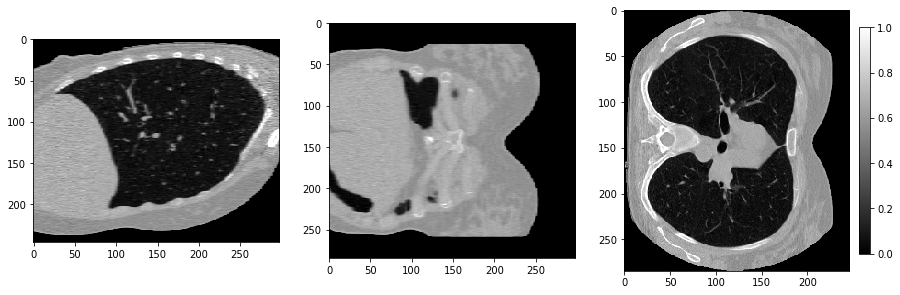

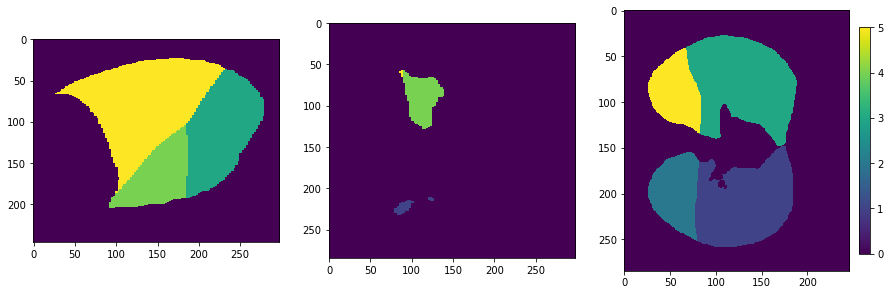

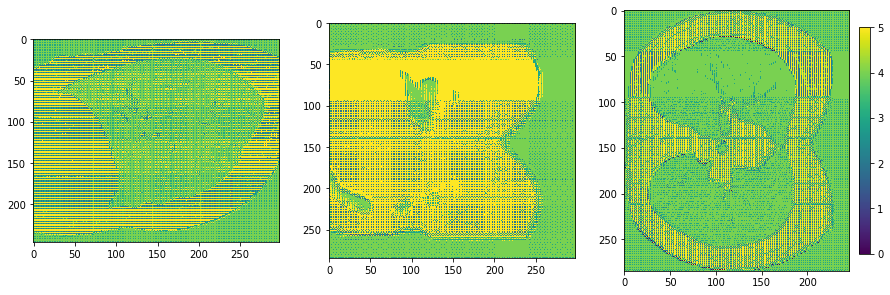

In [20]:
test_dices_df = DataFrame(test_dices.detach().cpu().numpy())
print(f"Average class scores: {class_means}")
print(f"Average score overall: {mean}")
# showslice(np_img, 200,200,200, is_gray=True)
# showslice(np_label, 200,200,200)
# showslice(output, 200,200,200)

In [7]:
images = sorted(glob.glob(os.path.join(config["data_dir"], config["image_type"])))
# Load data
val_loader = val_dataloader(config, images)
examples = []

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i >= 3:
            break
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        np_img = val_data["image"][0,0,:,:,:].detach().cpu().numpy()
        np_label = val_data["label"][0,0,:,:,:].detach().cpu().numpy()
        output = torch.argmax(val_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
        # showslice(np_img, 200, 200,200, is_gray=True)
        examples.append((np_img, np_label, output))

Validation sample size: 36


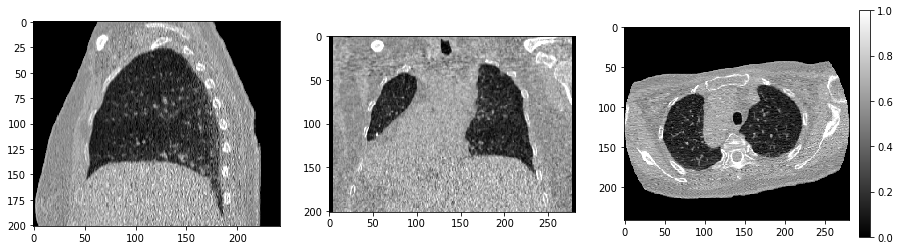

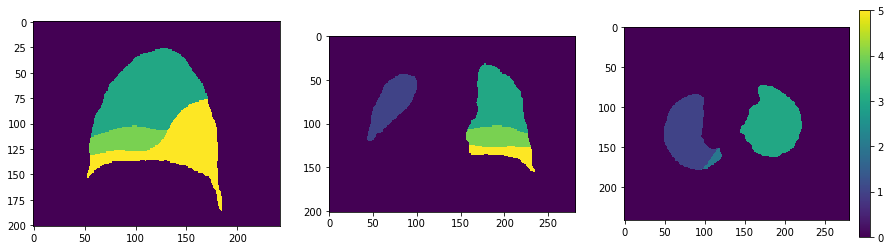

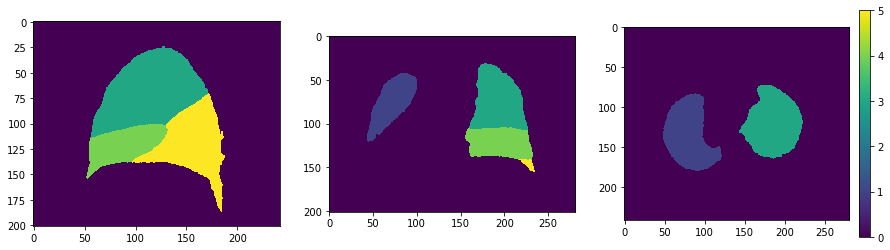

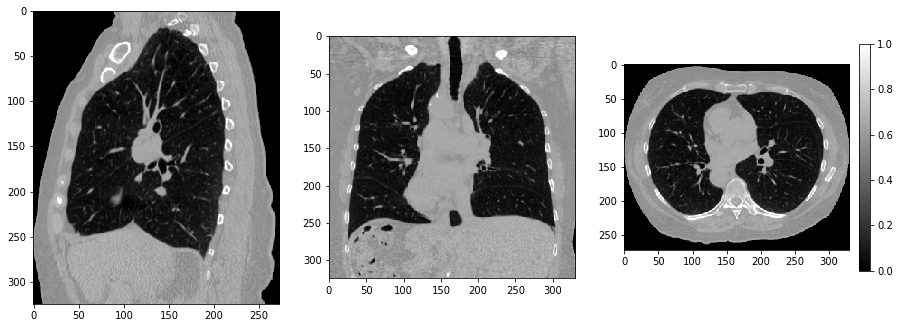

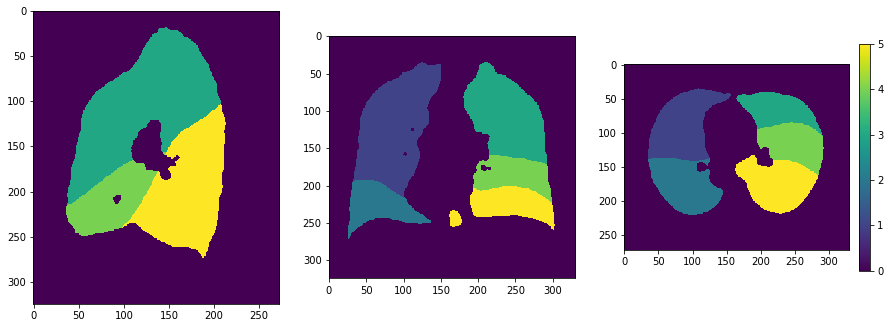

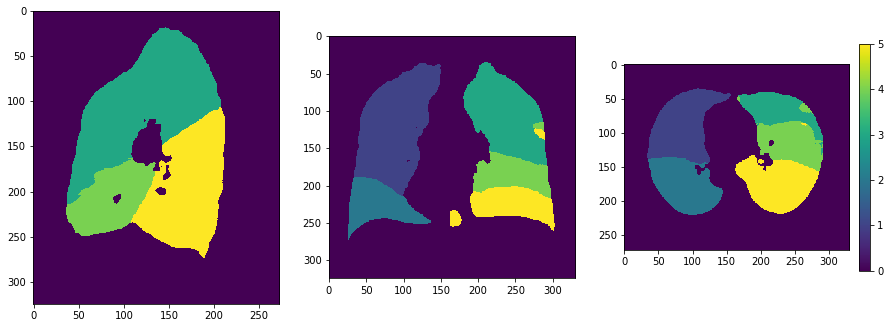

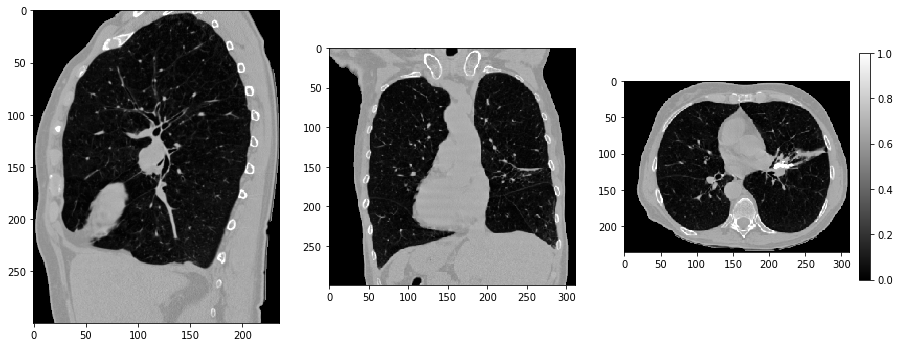

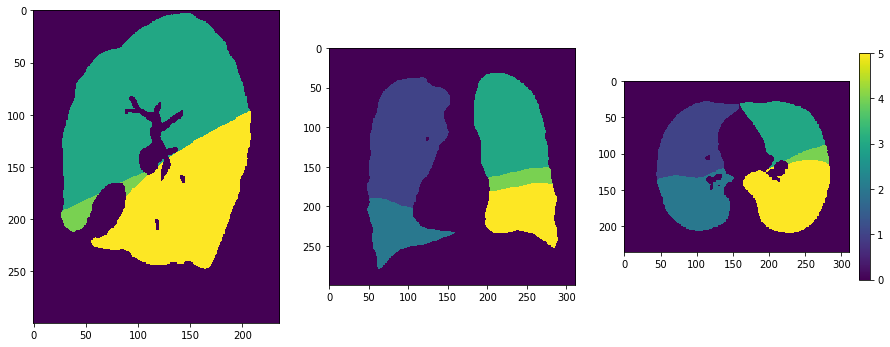

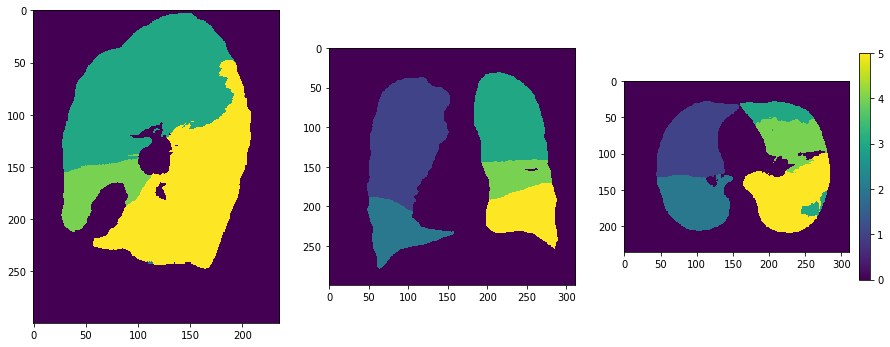

In [30]:
# without finetune
for i in range(3):
    vis.showslice(examples[i][0], 200, 150,150, is_gray=True)
    vis.showslice(examples[i][1], 200, 150, 150)
    vis.showslice(examples[i][2], 200, 150,150)

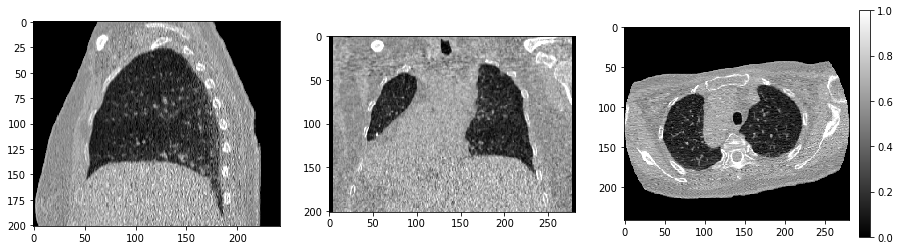

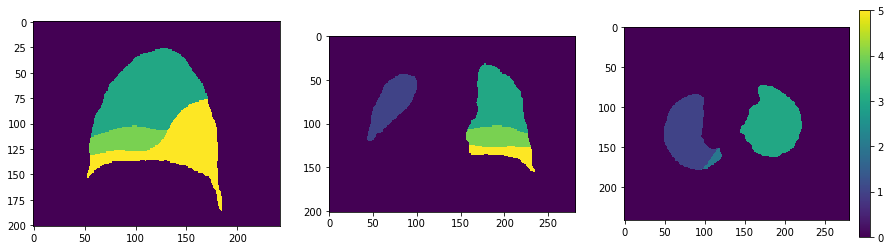

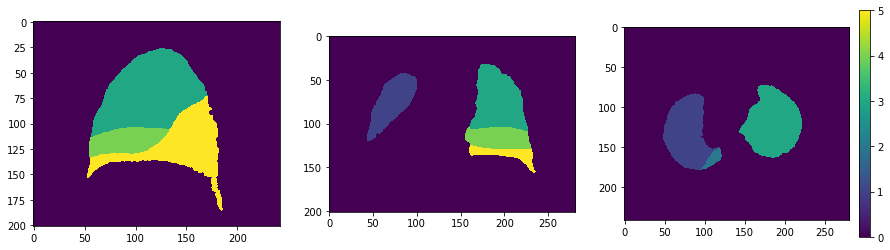

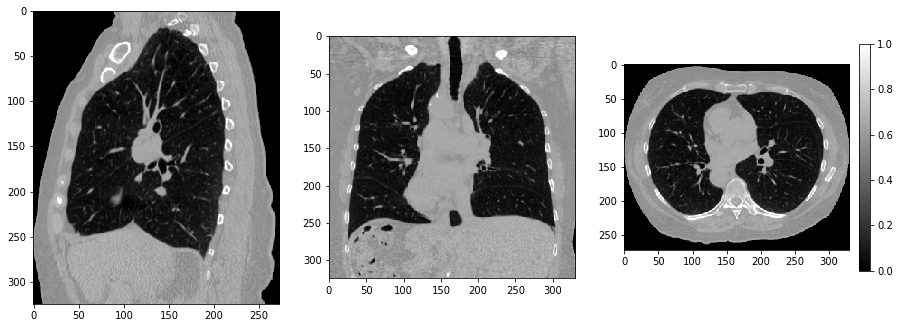

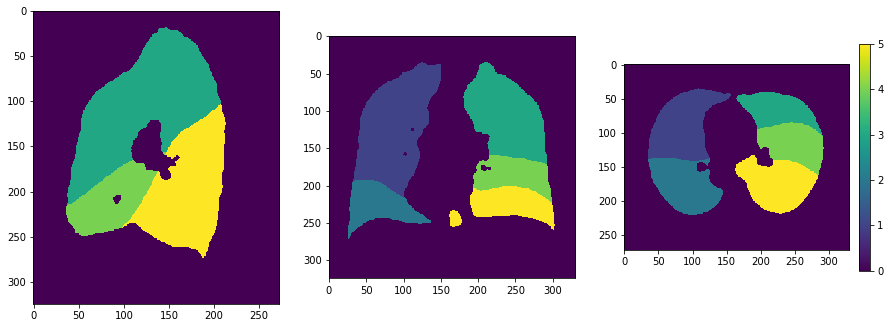

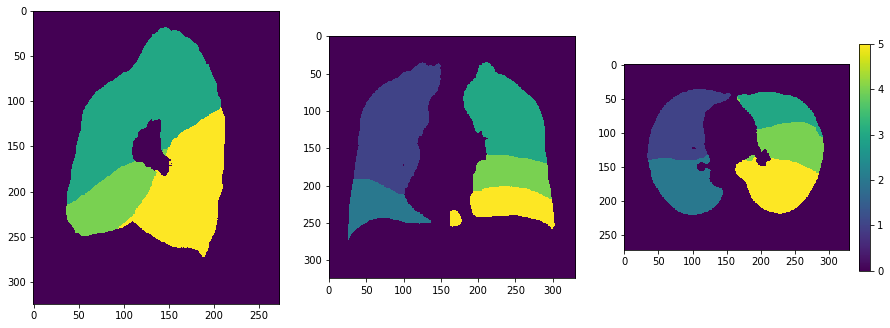

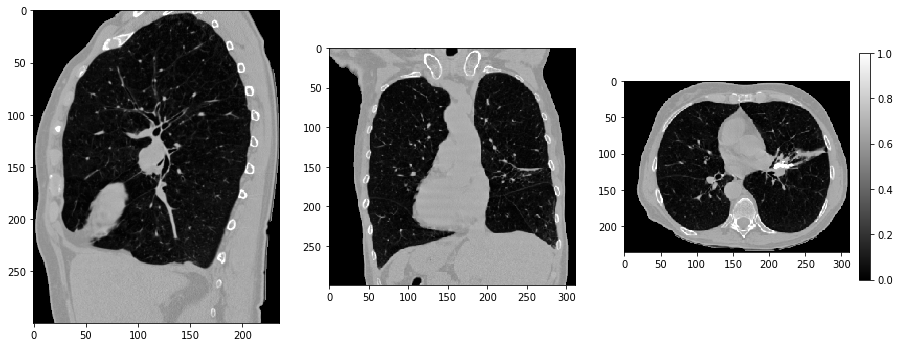

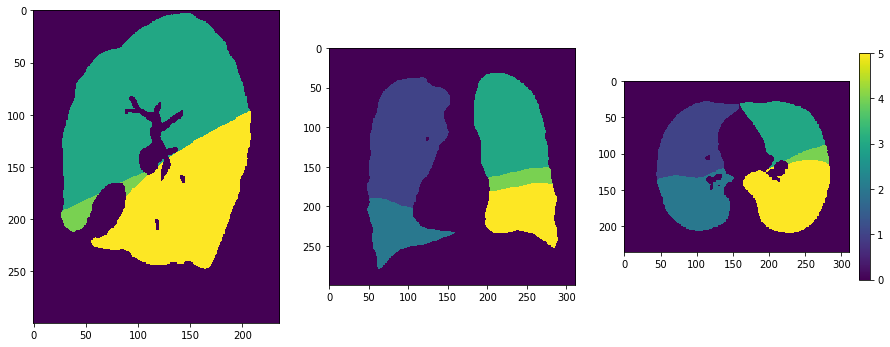

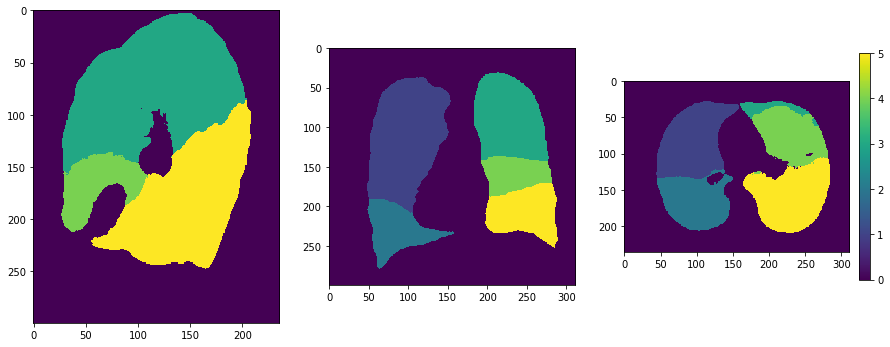

In [8]:
# with finetune
for i in range(3):
    vis.showslice(examples[i][0], 200, 150,150, is_gray=True)
    vis.showslice(examples[i][1], 200, 150, 150)
    vis.showslice(examples[i][2], 200, 150,150)